In [ ]:
%load_ext autoreload
%autoreload 2

from circuit_breaking.src import *
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from circuit_breaking.src.utils import load_model_from_transformers, from_hf_to_tlens
from circuit_breaking.src.masks import MLPHiddenMask
from tqdm.auto import tqdm
#torch.autograd.set_detect_anomaly(True) 

In [ ]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer
model_name_or_path = "google/gemma-7b"
model_type = "gemma"

tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

model = HookedTransformer.from_pretrained(
    'google/gemma-7b',
    tokenizer=tokenizer,
    device='cuda',

    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    dtype=torch.bfloat16
)

model.set_use_attn_result(True)

In [ ]:
import pickle
with open("models/google_gemma-7b_sports_all_ap_graph.pkl", "rb") as f:
    ap_graph = pickle.load(f)
ap_graph.keys()

In [ ]:
from tasks import PileTask, OWTTask, InductionTask, GreaterThanTask
from tasks.ioi.IOITask import IOITask, IOITask_NPO, IOITask_Uniform
from tasks.induction.InductionTask import InductionTask, InductionTask_NPO, InductionTask_Uniform
from tasks.facts.SportsTask import SportsTask, SportsTask_NPO, SportsTask_Uniform
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval
from tasks.facts.SportsTaskSideEffects import run_side_effects_evals


train_batch_size = 8
eval_batch_size=32

device = "cuda"
train_loss_type = "sports"
forget_sport = "basketball"
maintain_sport = None
# val_sport = "baseball"


sports_1mp = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="log_1_minus_p", forget_sport_subset={forget_sport}, is_forget_dataset=True)

if maintain_sport is None:
    maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={forget_sport}, is_forget_dataset=False)
else:
    maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={maintain_sport}, is_forget_dataset=True)

train_pile = PileTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, ctx_length=256, shuffle=True, buffer_size=50000)
train_tasks = {"sports_1mp": (sports_1mp, .2), "maintain_sports": (maintain_sports, 1), "pile": (train_pile, 1)}

# want to eval on other sports
forget_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={forget_sport}, is_forget_dataset=True)
test_pile = PileTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, ctx_length=100, shuffle=True, buffer_size=50000)

induction_eval = InductionTask(batch_size=eval_batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device)
if maintain_sport is None:
    maintain_sports_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={forget_sport}, is_forget_dataset=False)
    eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": forget_sport_eval, "maintain_sport": maintain_sports_eval}
else:
    maintain_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={maintain_sport}, is_forget_dataset=True)
    val_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={val_sport}, is_forget_dataset=True)
    eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": 
                  forget_sport_eval, "maintain_sport": maintain_sport_eval, "val_sport": val_sport_eval}

In [29]:
def convert_attrs_to_components(attrs, combine_heads=False, n_layers=model.cfg.n_layers, n_heads=model.cfg.n_heads):
    """
    attrs is dictionary of e.g. {'a0.0_q': float, 'm27_in': float}

    If combine_heads, then it will combine all 'a0.0_q', 'a0.1_q', ..., 'a0.15_q', etc into one component.
    """

    component_dict = defaultdict(int)
    attn_head_dict = defaultdict(dict)
    for layer in range(n_layers):
        for attn_type, component_name in [("q", f"blocks.{layer}.attn.hook_q"), ("k", f"blocks.{layer}.attn.hook_k"), ("v", f"blocks.{layer}.attn.hook_v"), ("result", f"blocks.{layer}.attn.hook_result")]:
            for head in range(n_heads):    
                if combine_heads:
                    component_dict[component_name] += attrs[f"a{layer}.{head}_{attn_type}"]
                else:
                    attn_head_dict[component_name][head] = attrs[f"a{layer}.{head}_{attn_type}"]
        for mlp_type, component_name in [("in", f"blocks.{layer}.mlp.hook_pre"), ("out", f"blocks.{layer}.mlp.hook_post")]:
            component_dict[component_name] += attrs[f"m{layer}_{mlp_type}"]
    if combine_heads:
        return (component_dict,)
    return (component_dict, attn_head_dict,)


def get_top_components(component_dict, attn_head_dict=None, threshold=None, top_p=None, top_k=None, use_abs=True, n_layers=model.cfg.n_layers, n_heads=model.cfg.n_heads):
    """
    component_dict is a dictionary of components to their importance values. If attn_head_dict is not None, then component_dict and attn_head_dict should not overlap in values.

    Can either use a threshold, top_p, or top_k to determine the top components to return (can only specify one). top_p should be a value ranging from 0 to 100. If use_abs is True, then it will take the absolute value of the importance values. 
    """
    if attn_head_dict is not None:
        assert (component_dict.keys() & attn_head_dict.keys()) == set(), "Overlapping keys between component_dict and attn_head_dict"
    
    # assert only one of threshold, top_p, top_k is specified
    assert sum([threshold is not None, top_p is not None, top_k is not None]) == 1, "Can only specify one of threshold, top_p, top_k"
    # will calculate a threshold for top_p or top_k

    if top_p is not None:
        all_attr_values = list(component_dict.values())
        if attn_head_dict is not None:
            all_attr_values += [val for head_dict in attn_head_dict.values() for val in head_dict.values()]

        all_attr_values = np.array(all_attr_values)
        if use_abs:
            all_attr_values = np.abs(all_attr_values)
        print(f"{len(all_attr_values)=}")
        threshold = np.percentile(all_attr_values, 100 - top_p)
    elif top_k is not None:
        all_attr_values = list(component_dict.values())
        if attn_head_dict is not None:
            all_attr_values += [val for head_dict in attn_head_dict.values() for val in head_dict.values()]

        all_attr_values = np.array(all_attr_values)
        if use_abs:
            all_attr_values = np.abs(all_attr_values)
        threshold = np.sort(all_attr_values)[-top_k]
    
    print(f"Thresholding importance at {threshold}")
    final_components = []
    final_attn_heads = defaultdict(list)

    for component, importance in component_dict.items():
        if use_abs:
            importance = abs(importance)
        if importance >= threshold:
            final_components.append(component)    

    if attn_head_dict is not None:
        for component, head_dict in attn_head_dict.items():
            head_list = []
            for head, importance in head_dict.items():
                if use_abs:
                    importance = abs(importance)
                if importance >= threshold:
                    head_list.append(head)
            if len(head_list) > 0:
                final_attn_heads[component] = head_list
                final_components.append(component)
    else:
        for component in final_components:
            if "attn" in component:
                # want to mask over all possible heads
                final_attn_heads[component] = list(range(n_heads))
    
    return final_components, final_attn_heads
print(get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=True), top_p=5))
print(get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=False), top_k=20))


len(all_attr_values)=168
Thresholding importance at 0.20463522672653203
(['blocks.18.attn.hook_result', 'blocks.21.mlp.hook_pre', 'blocks.21.mlp.hook_post', 'blocks.23.mlp.hook_post', 'blocks.25.attn.hook_result', 'blocks.25.mlp.hook_pre', 'blocks.27.attn.hook_q', 'blocks.27.attn.hook_k', 'blocks.27.mlp.hook_post'], defaultdict(<class 'list'>, {'blocks.18.attn.hook_result': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'blocks.25.attn.hook_result': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'blocks.27.attn.hook_q': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'blocks.27.attn.hook_k': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}))
Thresholding importance at 0.11414513221153846
(['blocks.0.mlp.hook_pre', 'blocks.13.mlp.hook_pre', 'blocks.19.mlp.hook_pre', 'blocks.20.mlp.hook_post', 'blocks.21.mlp.hook_pre', 'blocks.21.mlp.hook_post', 'blocks.22.mlp.hook_post', 'blocks.23.mlp.hook_pre', 'blocks.23.mlp.hook_post', 'blocks.25.mlp.hook_pre', 'bloc

In [33]:
# ct components
with open("models/google_gemma-7b_sports_all_ct_graph.pkl", "rb") as f:
    ct_graph = pickle.load(f)
ct_graph

def get_top_components_no_subcomponents(attrs, threshold=None, top_p=None, top_k=None, use_abs=True, n_layers=model.cfg.n_layers, n_heads=model.cfg.n_heads, combine_heads=False):
    combined_attrs = {}
    # if combine heads, then we will combine all heads into one component per layer
    if combine_heads:
        for layer in range(n_layers):
            combined_attrs[f"a{layer}"] = 0
            for head in range(n_heads):
                combined_attrs[f"a{layer}"] += attrs[f"a{layer}.{head}"]
            
            combined_attrs[f"m{layer}"] = attrs[f"m{layer}"]
    else:
        combined_attrs = attrs

    assert sum([threshold is not None, top_p is not None, top_k is not None]) == 1, "Can only specify one of threshold, top_p, top_k"

    if top_p is not None:
        all_attr_values = list(combined_attrs.values())

        all_attr_values = np.array(all_attr_values)
        if use_abs:
            all_attr_values = np.abs(all_attr_values)
        print(f"{len(all_attr_values)=}")
        threshold = np.percentile(all_attr_values, 100 - top_p)

    elif top_k is not None:
        all_attr_values = list(combined_attrs.values())

        all_attr_values = np.array(all_attr_values)
        if use_abs:
            all_attr_values = np.abs(all_attr_values)
        threshold = np.sort(all_attr_values)[-top_k]
    
    print(f"Thresholding importance at {threshold}")

    final_components = set()
    final_attn_heads = defaultdict(list)

    for component, importance in combined_attrs.items():
        if use_abs:
            importance = abs(importance)
        if importance >= threshold:
            print(f"{component=}, {importance=} is being added")
            # if combine heads, then we will only have one component per layer
            if combine_heads:
                layer = int(component[1:])
                # convert to component name
                if component[0] == "a":
                    # add q, k, v, result to tunable params
                    for attn_type in ['q', 'k', 'v', 'result']:
                        final_components.add(f"blocks.{layer}.attn.hook_{attn_type}")
                        final_attn_heads[f"blocks.{layer}.attn.hook_{attn_type}"] = list(range(n_heads))
                else:
                    # add in, out to tunable params
                    for mlp_type in ['pre', 'post']:
                        final_components.add(f"blocks.{layer}.mlp.hook_{mlp_type}")
            else:
                layer = int(component.split(".")[0][1:])
                if component[0] == "a":
                    head = int(component.split(".")[1])
                    # add q, k, v, result to tunable params
                    for attn_type in ['q', 'k', 'v', 'result']:
                        final_components.add(f"blocks.{layer}.attn.hook_{attn_type}")
                        final_attn_heads[f"blocks.{layer}.attn.hook_{attn_type}"].append(head)

                else:
                    # add in, out to tunable params
                    for mlp_type in ['pre', 'post']:
                        final_components.add(f"blocks.{layer}.mlp.hook_{mlp_type}")
    return final_components, final_attn_heads

print(get_top_components_no_subcomponents(ct_graph, top_p=2, combine_heads=True))
print(get_top_components_no_subcomponents(ct_graph, top_p=2, combine_heads=False))

len(all_attr_values)=56
Thresholding importance at 1.7825241088867185
component='m22', importance=1.796875 is being added
component='a25', importance=1.9869384765625 is being added
({'blocks.25.attn.hook_v', 'blocks.25.attn.hook_k', 'blocks.22.mlp.hook_post', 'blocks.25.attn.hook_result', 'blocks.25.attn.hook_q', 'blocks.22.mlp.hook_pre'}, defaultdict(<class 'list'>, {'blocks.25.attn.hook_q': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'blocks.25.attn.hook_k': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'blocks.25.attn.hook_v': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'blocks.25.attn.hook_result': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}))
len(all_attr_values)=476
Thresholding importance at 0.7065505981445312
component='a20.4', importance=0.85272216796875 is being added
component='a21.4', importance=0.9078369140625 is being added
component='m21', importance=1.077880859375 is being added
component='a22.15', importance=1.20556640625 i

In [ ]:
def get_random_components(n_layers=model.cfg.n_layers, n_heads=model.cfg.n_heads, top_p=None, top_k=None):
    # select random subset of q, k, v, result, out, in. No combine_heads parameter because I don't think it makes sense to equally randomly select one 256-d head mask vs one 25k-d mlp mask
    if combine_heads:
        all_possible_components = []


## Train Masks

In [ ]:
mask_type = 'localized_ct'

combine_heads = False
top_p = 5

if mask_type == 'localized_ap':
    final_components, final_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=combine_heads), top_p=top_p)

    print(final_components)
    print(final_attn_heads)

    mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

elif mask_type == 'localized_ct':
    final_components, final_attn_heads = get_top_components_no_subcomponents(ct_graph, top_p=top_p, combine_heads=combine_heads)

    print(final_components)
    print(final_attn_heads)

    mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

elif mask_type == 'manual_interp':
    final_components = []
    for mlp_layer in range(1, 8):
        final_components.append(f"blocks.{mlp_layer}.mlp.hook_pre")
        final_components.append(f"blocks.{mlp_layer}.mlp.hook_post")
    final_attn_heads = {}
    mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

elif mask_type == 'random':
    

elif mask_type == 'nonlocalized':
    all_components, all_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=combine_heads), top_p=100)
    print(len(all_components))
    print(len(all_attn_heads))
    assert (torch.tensor([len(x) for x in all_attn_heads.values()]) == model.cfg.n_heads).all()

    mask = NeuronLevelMask(model, components=all_components, component_heads=all_attn_heads)


In [ ]:
for name, param in mask.named_parameters():
    print(name, param.shape, param.requires_grad)

In [ ]:
# mask = MLPHiddenMask(model).cuda()

learning_rate = 5e-2
n_epochs = 50
grad_accum_steps = 16
# max_gpu_batch_size=8
beta = 3
clip_grad = 1

evaluate_every = 5
n_eval_iters = 5
deep_evaluate_every = 25
do_adversarial_evals = True
do_side_effects_evals = False

from collections import defaultdict
all_train_losses = defaultdict(list)
all_test_losses = defaultdict(list)
adversarial_evals = []
side_effect_evals = []
mask.cuda()

# Initialize optimizer

optimizer = torch.optim.AdamW(mask.parameters(), lr=learning_rate, weight_decay=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_epochs)
# Cycle dataloaders
# Train a sparse mask
pbar = tqdm(range(n_epochs))
for epoch in pbar:
    # Sample batches
    # Reset grad
    optimizer.zero_grad()
    # Compute normal loss over retain
    for task_name, (task, task_weight) in train_tasks.items():
        task_loss = 0
        for i in range(grad_accum_steps):
            loss = task.get_train_loss(model) / grad_accum_steps
            task_loss += loss.item()
            loss *= task_weight
            loss.backward()
        all_train_losses[task_name].append(task_loss)
        
    # Add sparsity loss and backprop
    loss = beta * mask.regularization_loss()
    loss.backward()
    all_train_losses["reg"].append(loss.item())
    # Step and log
    if clip_grad is not None:
        torch.nn.utils.clip_grad_norm_(mask.parameters(), clip_grad)
    # zero_nan_grads(mask)
    optimizer.step()
    mask.on_step_end()
    scheduler.step()

    if epoch % evaluate_every == 0 or epoch == n_epochs - 1:
        for task_name, task in eval_tasks.items():
            task_loss = 0
            for i in range(n_eval_iters):
                task_loss += task.get_test_loss(model).item()
            all_test_losses[task_name].append(task_loss / n_eval_iters)
    if epoch % deep_evaluate_every == 0 or epoch == n_epochs - 1:
        if do_adversarial_evals:
            print("Running adversarial evals")
            adversarial_evals.append(adversarial_sports_eval(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=True))
        if do_side_effects_evals:
            print("Running side effects evals")
            side_effect_evals.append(run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["Sports Answers"]))
    

In [ ]:
# save masks state dict to neuron_cb
import pickle
torch.save(mask.state_dict(), f"masks/neuron_cb/{model_type}_{mask_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport}.pt")

with open(f"masks/neuron_cb/{model_type}_{mask_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport}_metrics.pkl", "wb") as f:
    pickle.dump({"train_losses": all_train_losses, "test_losses": all_test_losses, "adversarial_evals": adversarial_evals, "side_effect_evals": side_effect_evals}, f)



## Analyze Mask

In [16]:
model.cpu()


beta = 3
top_p = 5

mask_paths = {"localized_ap": "masks/neuron_cb/gemma_localized_combine_heads=False_beta=3_unlearn_basketball.pt", 
         "manual_interp": "masks/neuron_cb/gemma_manual_interp_combine_heads=False_beta=3_unlearn_basketball.pt",
         "nonlocalized": "masks/neuron_cb/gemma_nonlocalized_combine_heads=False_beta=3_unlearn_basketball.pt"}

masks = {}
models = {}

for mask_type, mask_path in mask_paths.items():
    model = HookedTransformer.from_pretrained(
        'google/gemma-7b',
        tokenizer=tokenizer,
        device='cpu',
        default_padding_side="right",
        fold_ln=False,
        fold_value_biases=False,
        center_writing_weights=False,
        dtype=torch.bfloat16
    )
    model.set_use_attn_result(True)

    if mask_type == 'localized_ap':
        final_components, final_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=combine_heads), top_p=top_p)

        print(final_components)
        print(final_attn_heads)

        mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

    elif mask_type == 'manual_interp':
        final_components = []
        for mlp_layer in range(1, 8):
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_pre")
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_post")
        final_attn_heads = {}
        mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

    elif mask_type == 'nonlocalized':
        all_components, all_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=combine_heads), top_p=100)
        print(len(all_components))
        print(len(all_attn_heads))
        assert (torch.tensor([len(x) for x in all_attn_heads.values()]) == model.cfg.n_heads).all()

        mask = NeuronLevelMask(model, components=all_components, component_heads=all_attn_heads)
    
    mask.load_state_dict(torch.load(mask_path))
    models[mask_type] = model
    masks[mask_type] = mask

# nonlocalized_model = HookedTransformer.from_pretrained(
#     'google/gemma-7b',
#     tokenizer=tokenizer,
#     device='cuda',
#     default_padding_side="right",
#     fold_ln=False,
#     fold_value_biases=False,
#     center_writing_weights=False,
#     dtype=torch.bfloat16
# )

# nonlocalized_model.set_use_attn_result(True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-7b into HookedTransformer


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-7b into HookedTransformer
len(all_attr_values)=1848
Thresholding importance at 5.498310177004622e-15
168
112


In [ ]:
# # use_localized_mask = False

# combine_heads = False
# top_p = 5
# beta = 3

# # if use_localized_mask:
# final_components, final_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=combine_heads), top_p=top_p)

# print(final_components)
# print(final_attn_heads)

# localized_mask = NeuronLevelMask(localized_model, components=final_components, component_heads=final_attn_heads)


# all_components, all_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=combine_heads), top_p=100)
# print(len(all_components))
# print(len(all_attn_heads))
# assert (torch.tensor([len(x) for x in all_attn_heads.values()]) == model.cfg.n_heads).all()

# nonlocalized_mask = NeuronLevelMask(nonlocalized_model, components=all_components, component_heads=all_attn_heads)

# # mask.load_state_dict(torch.load(f"masks/neuron_cb/{model_type}_{'localized' if use_localized_mask else 'nonlocalized'}_{combine_heads=}_unlearn_{forget_sport}.pt"))
# localized_mask.load_state_dict(torch.load(f"masks/neuron_cb/{model_type}_localized_{combine_heads=}_{beta=}_unlearn_{forget_sport}.pt"))
# nonlocalized_mask.load_state_dict(torch.load(f"masks/neuron_cb/{model_type}_nonlocalized_{combine_heads=}_{beta=}_unlearn_{forget_sport}.pt"))

# localized_mask.cuda()
# nonlocalized_mask.cuda()

In [ ]:

# with open(f"masks/neuron_cb/{model_type}_{'localized' if use_localized_mask else 'nonlocalized'}_{combine_heads=}_unlearn_{forget_sport}_metrics.pkl", "rb") as f:
#     metrics = pickle.load(f)

# metrics['test_losses']['pile']

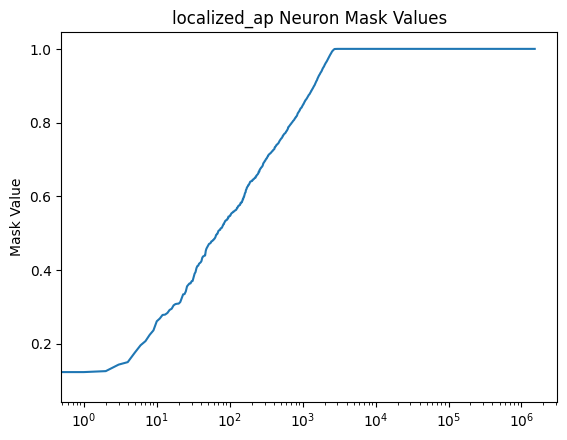

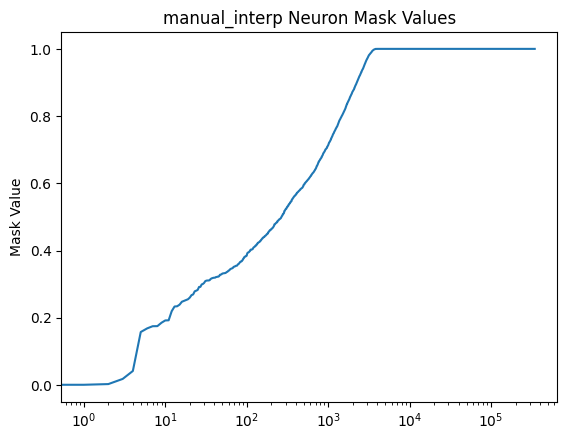

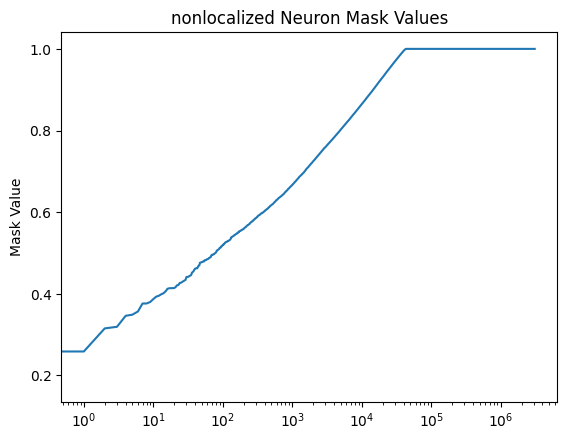

In [17]:
# Visualize the neuron coefficients
# for title, mask in [("Localized", localized_mask), ("Non-Localized", nonlocalized_mask)]:
for title, mask in masks.items():
    all_values = torch.cat([m.data.flatten() for m in mask.masks.values()], dim=0).cpu()
    sorted_values = all_values.sort().values
    plt.semilogx(sorted_values)
    plt.title(f"{title} Neuron Mask Values")
    plt.ylabel("Mask Value")
    plt.show()
# all_values = torch.cat([m.data.flatten() for m in mask.masks.values()], dim=0).cpu()
# sorted = all_values.sort().values
# plt.semilogx(sorted)
# plt.title("Neuron Mask Values")
# plt.ylabel("Mask Value")
# plt.show()

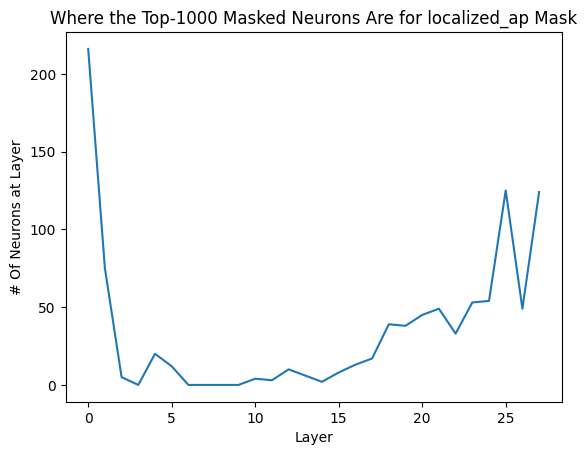

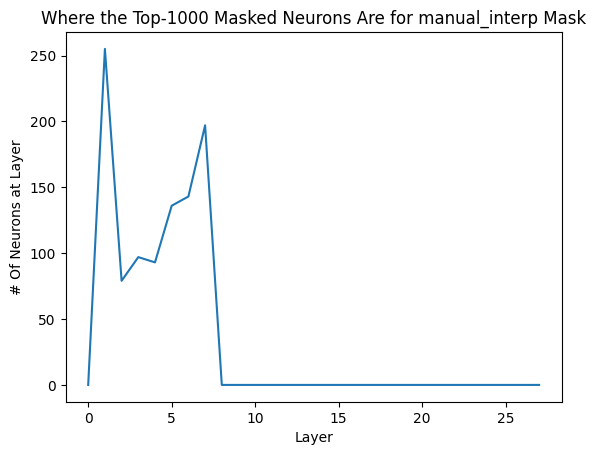

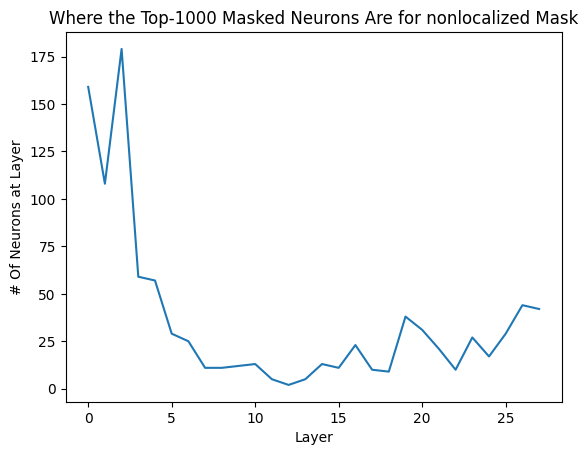

In [18]:
# Visualize the neuron coefficients
top_k = 1000
# for title, mask in [("Localized", localized_mask), ("Non-Localized", nonlocalized_mask)]:
for title, mask in masks.items():
    mask.undiscretize()
    mask.discretize_topk(top_k)
    all_values = {layer: 0 for layer in range(model.cfg.n_layers)}
    for component in mask.mask_masks:
        layer = int(component.split("&")[1])
        all_values[layer] += (mask.mask_masks[component].data == 1).sum().item()

    # all_values = [(m.data == 1).sum().item() for m in mask.mask_masks.values()]
    plt.plot(all_values.values())
    plt.title(f"Where the Top-{top_k} Masked Neurons Are for {title} Mask")
    plt.ylabel("# Of Neurons at Layer")
    plt.xlabel("Layer")
    plt.show()

In [19]:
torch.cuda.empty_cache()
torch.cuda.memory_allocated() // 1024 // 1024 // 1024

0

In [21]:
# Final evals
# for title, mask in [("Localized", localized_mask), ("Non-Localized", nonlocalized_mask)]:
for title, mask in masks.items():
    print(f"Final evals for {title} Mask")
    model = models[title]
    model.cuda()
    mask.cuda()
    mask.undiscretize()

    final_adversarial_eval = adversarial_sports_eval(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=True, continuous=False)
    print(f"System Prompt: adversarial evals are {final_adversarial_eval}")
    final_adversarial_eval = adversarial_sports_eval(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=False, continuous=False)
    print(f"No System Prompt: adversarial evals are {final_adversarial_eval}")

    final_side_effects = run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["Sports Answers", "Cross Entropy"], verbose=True)
    print(final_side_effects)

    model.cpu()
    mask.cpu()

Final evals for localized_ap Mask
Moving model to device:  cuda


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


System Prompt: adversarial evals are {'Normal': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.04375}, 'MC': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.5625}, 'Capitalized': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.0625}, 'Dashed': {'football': 0.76875, 'baseball': 1.0, 'basketball': 0.15}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No System Prompt: adversarial evals are {'Normal': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.018750000000000003}, 'MC': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.425}, 'Capitalized': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.03125}, 'Dashed': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.0875}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Sports Answers:
football: 50/50
baseball: 50/50
basketball: 36/50
tennis: 46/50


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Pile Cross Entropy: 2.3
OWT Cross Entropy: 2.521875
{'Sports Answers': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.72, 'tennis': 0.92}, 'Cross Entropy': {'Pile': 2.3, 'OWT': 2.521875}}
Moving model to device:  cpu
Final evals for manual_interp Mask
Moving model to device:  cuda
System Prompt: adversarial evals are {'Normal': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.04375}, 'MC': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.06874999999999999}, 'Capitalized': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.037500000000000006}, 'Dashed': {'football': 0.71875, 'baseball': 1.0, 'basketball': 0.125}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No System Prompt: adversarial evals are {'Normal': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.0375}, 'MC': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.0875}, 'Capitalized': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.018750000000000003}, 'Dashed': {'football': 0.98125, 'baseball': 1.0, 'basketball': 0.05}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Sports Answers:
football: 50/50
baseball: 50/50
basketball: 36/50
tennis: 43/50


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Pile Cross Entropy: 2.30625
OWT Cross Entropy: 2.521875
{'Sports Answers': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.72, 'tennis': 0.86}, 'Cross Entropy': {'Pile': 2.30625, 'OWT': 2.521875}}
Moving model to device:  cpu
Final evals for nonlocalized Mask
Moving model to device:  cuda
System Prompt: adversarial evals are {'Normal': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.0125}, 'MC': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.34375}, 'Capitalized': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.025}, 'Dashed': {'football': 0.23750000000000002, 'baseball': 1.0, 'basketball': 0.0}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No System Prompt: adversarial evals are {'Normal': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.0125}, 'MC': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.3125}, 'Capitalized': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.03125}, 'Dashed': {'football': 0.65, 'baseball': 1.0, 'basketball': 0.043750000000000004}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Sports Answers:
football: 50/50
baseball: 49/50
basketball: 19/50
tennis: 38/50


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Pile Cross Entropy: 2.33125
OWT Cross Entropy: 2.553125
{'Sports Answers': {'football': 1.0, 'baseball': 0.98, 'basketball': 0.38, 'tennis': 0.76}, 'Cross Entropy': {'Pile': 2.33125, 'OWT': 2.553125}}
Moving model to device:  cpu


### Scatterplot

In [ ]:
localized_mask.masks

In [ ]:
for title, mask in [("Localized", localized_mask), ("Non-Localized", nonlocalized_mask)]:
    print(f"Final evals for {title} Mask")

    for component in localized_mask.masks:

### Pareto Plots

In [23]:
# mask_k_vals = [1, 2, 5, 10, 20, 40, 80, 160, 320, 640]
mask_k_vals = [10, 20, 40, 80, 160, 200, 320, 480, 640, 960]
# mask_k_vals = [25, 50, 100, 150, 200, 300, 400, 600, 800, 1200, 1600]
# mask_k_vals = [5, 160]

# for regular evals, use the same task evals
# localized_regular_evals = {}
# nonlocalized_regular_evals = {}

# localized_side_effect_evals = {}
# localized_adversarial_evals = {}
# nonlocalized_side_effect_evals = {}
# nonlocalized_adversarial_evals = {}

all_regular_evals = {}
all_side_effect_evals = {}
all_adversarial_evals = {}

In [25]:
n_eval_iters = 15

# for name, model, mask, regular_evals, side_effect_evals, adversarial_evals in [("localized", localized_model, localized_mask, localized_regular_evals, localized_side_effect_evals, localized_adversarial_evals), ("nonlocalized", nonlocalized_model, nonlocalized_mask, nonlocalized_regular_evals, nonlocalized_side_effect_evals, nonlocalized_adversarial_evals)]:
for name in masks:
    model = models[name]
    mask = masks[name]
    model.cuda()
    mask.cuda()

    regular_evals = {}
    side_effect_evals = {}
    adversarial_evals = {}
    for k in tqdm(mask_k_vals):
        mask.undiscretize()
        mask.discretize_topk(k)
        
        # first do the regular evals
        regular_evals[k] = {}
        for task_name, task in eval_tasks.items():
            task_loss = 0
            task_accuracy = 0
            for i in range(n_eval_iters):
                task_loss += task.get_test_loss(model).item()
                task_accuracy += task.get_test_accuracy(model)
            regular_evals[k][f"{task_name}_ce"] = task_loss / n_eval_iters
            regular_evals[k][f"{task_name}_acc"] = task_accuracy / n_eval_iters

        # then do the side effect evals
        side_effect_evals[k] = run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["Sports Answers", "Cross Entropy"], verbose=False, n_iters=n_eval_iters) # output is dictionary of dictionaries, first keys are eval_types ("Sports Answers", "Cross Entropy"), and nested keys are either different sports or different cross entropy measures, and nested values are eval values

        # then do the adversarial evals
        adversarial_evals[k] = adversarial_sports_eval(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=True, continuous=True, n_iters=n_eval_iters) # output is a dictionary of dictionaries, first keys are eval_types ("Normal", "MC", "Capitalized", "Dashed"), and nested keys are different sports ("baseball", "football", "basketball"), and nested values are accuracies

    all_regular_evals[name] = regular_evals
    all_side_effect_evals[name] = side_effect_evals
    all_adversarial_evals[name] = adversarial_evals

    model.cpu()
    mask.cpu()

Moving model to device:  cuda


  0%|          | 0/10 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Moving model to device:  cpu
Moving model to device:  cuda


  0%|          | 0/10 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Moving model to device:  cpu
Moving model to device:  cuda


  0%|          | 0/10 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Moving model to device:  cpu


In [26]:
# save all results
with open(f"results/neuron_cb_{beta=}_pareto_comparisons.pkl", "wb") as f:
    # pickle.dump({"localized_regular_evals": localized_regular_evals, "localized_side_effect_evals": localized_side_effect_evals, "localized_adversarial_evals": localized_adversarial_evals, "nonlocalized_regular_evals": nonlocalized_regular_evals, "nonlocalized_side_effect_evals": nonlocalized_side_effect_evals, "nonlocalized_adversarial_evals": nonlocalized_adversarial_evals}, f)
    pickle.dump({"all_regular_evals": all_regular_evals, "all_side_effect_evals": all_side_effect_evals, "all_adversarial_evals": all_adversarial_evals}, f)

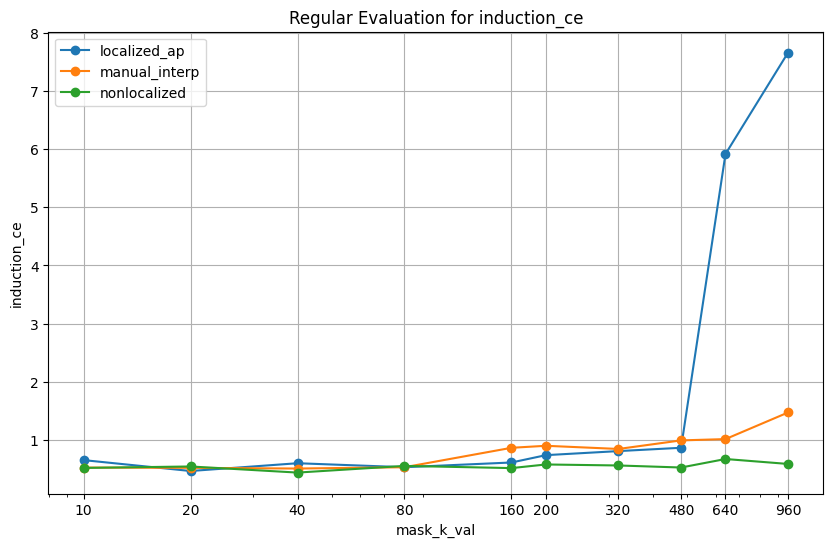

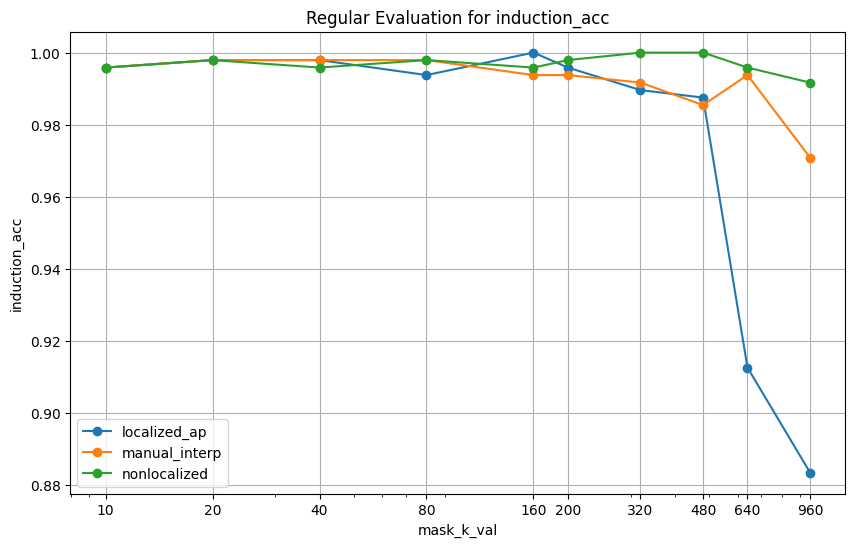

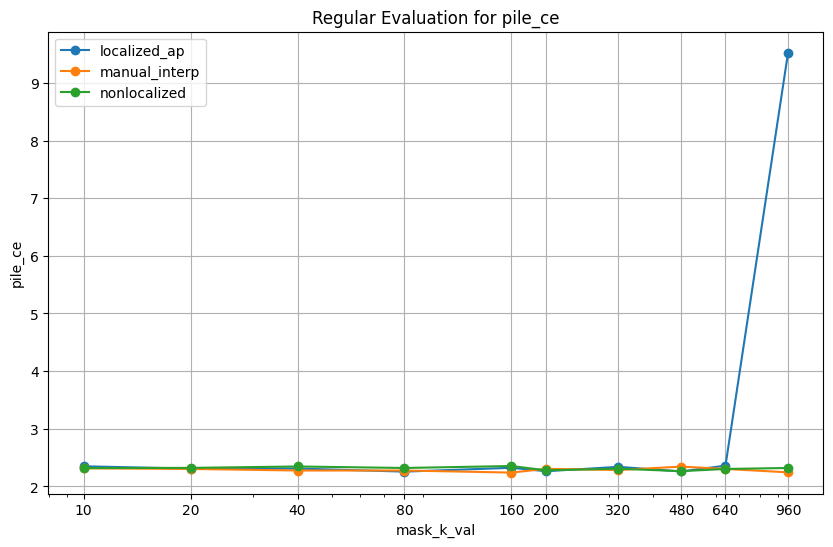

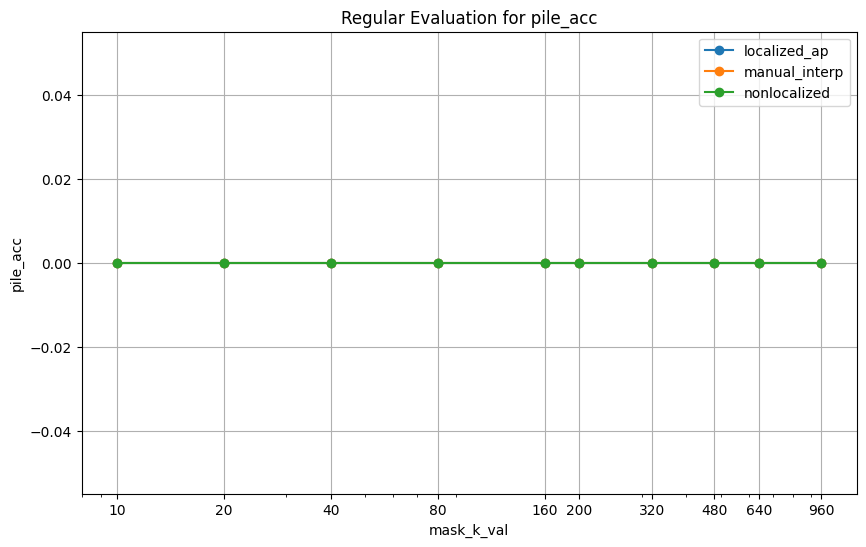

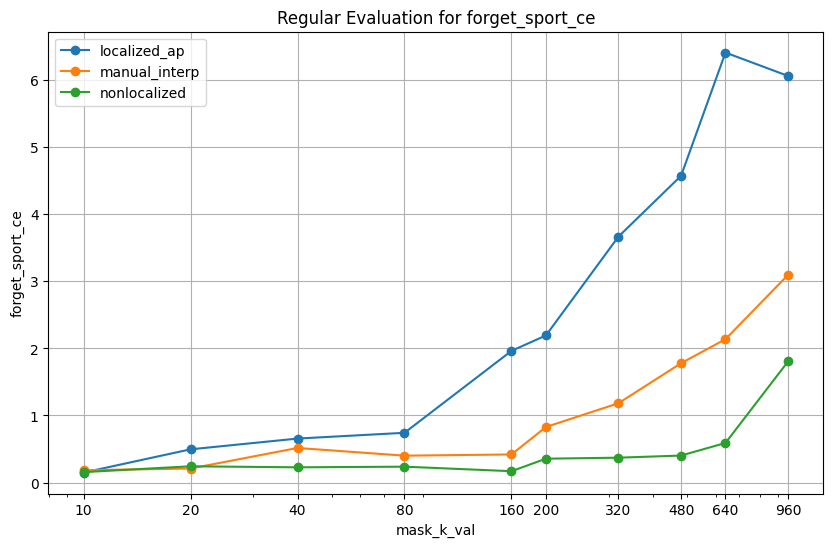

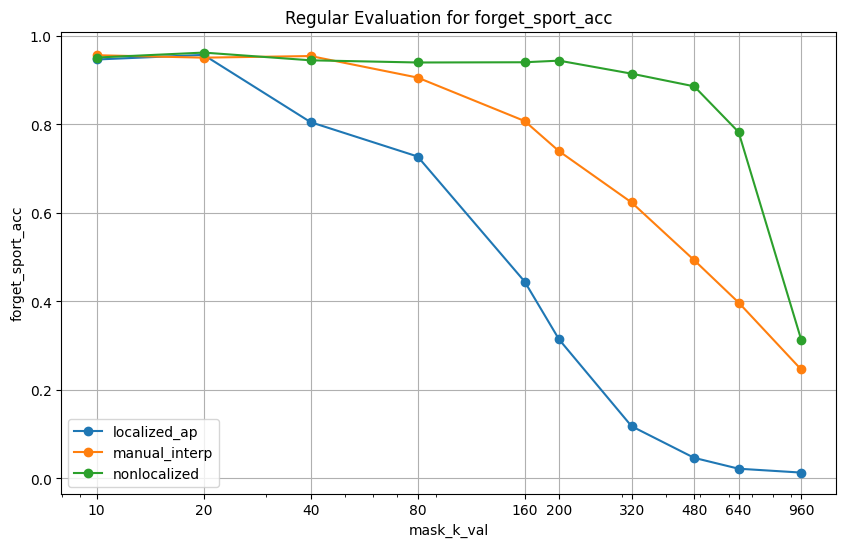

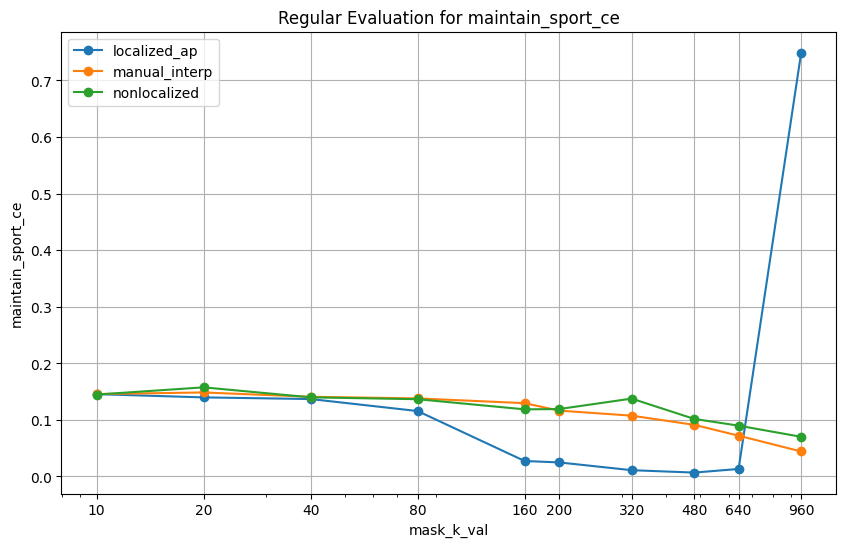

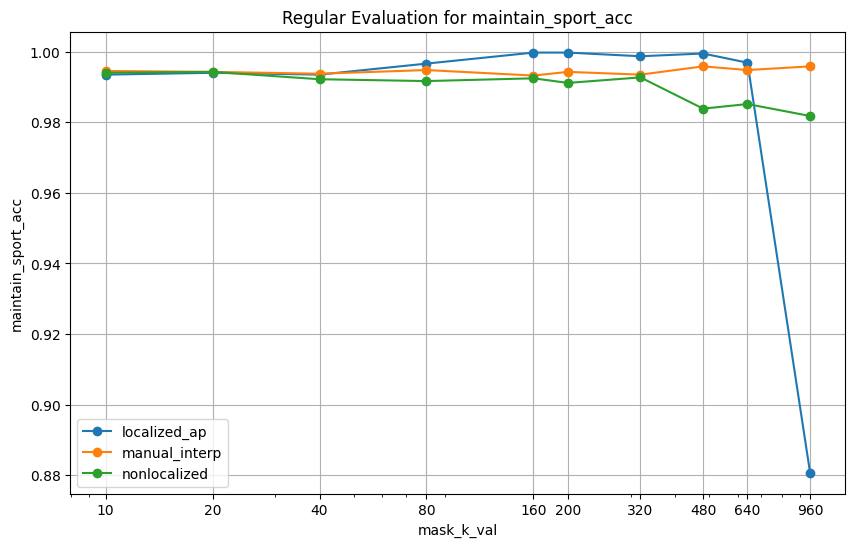

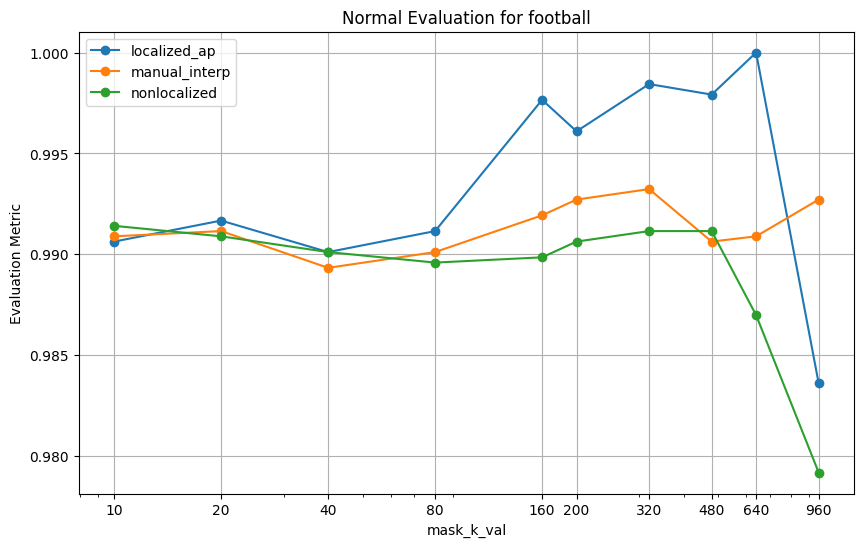

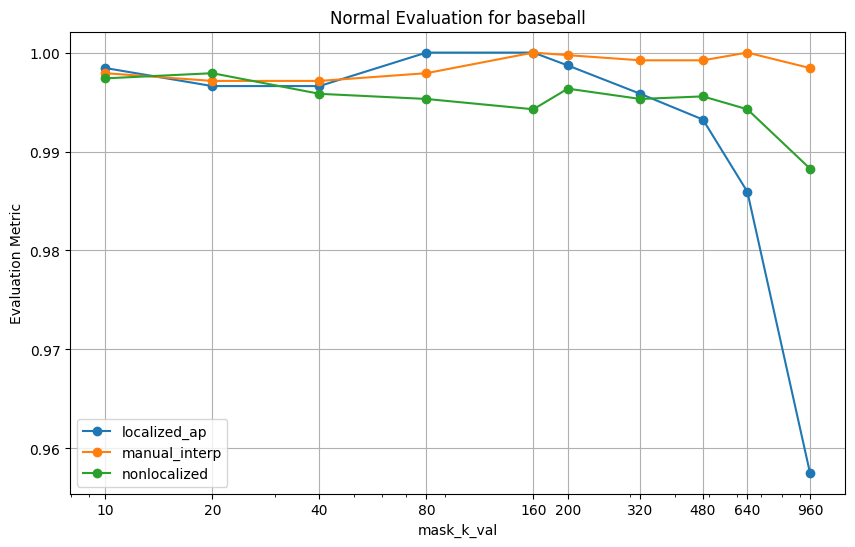

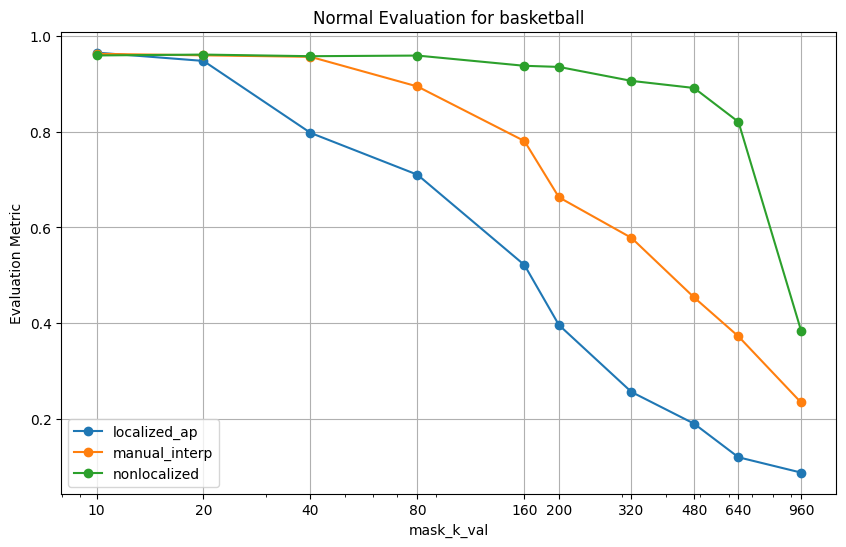

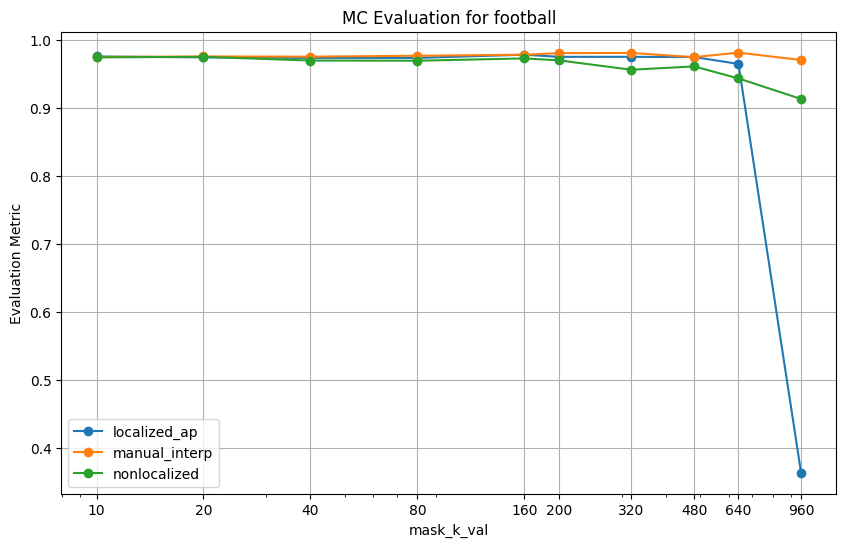

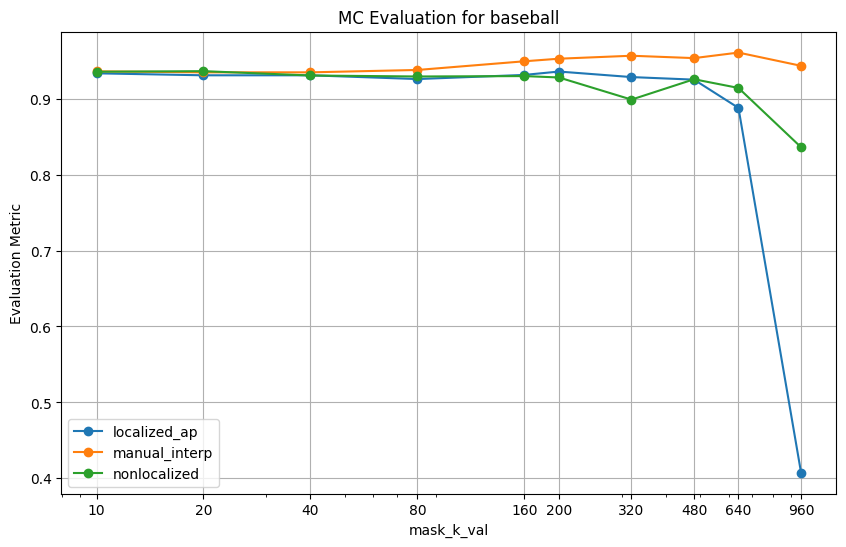

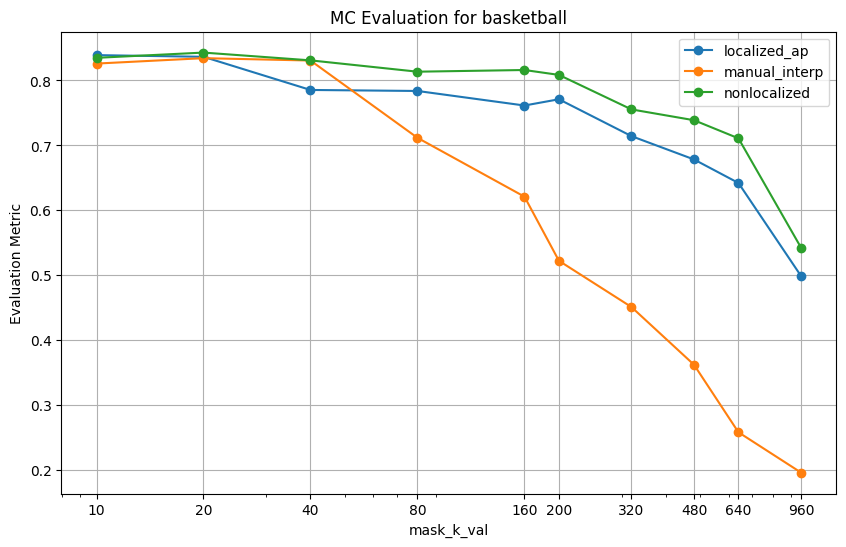

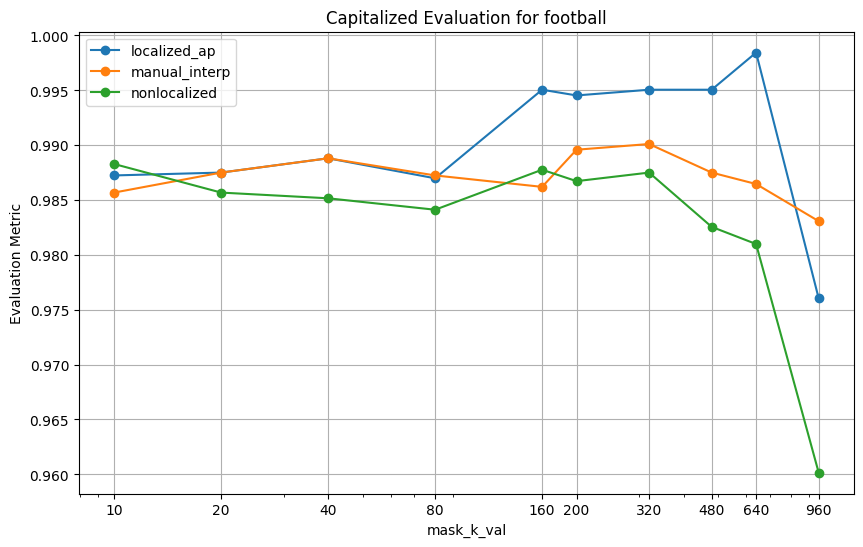

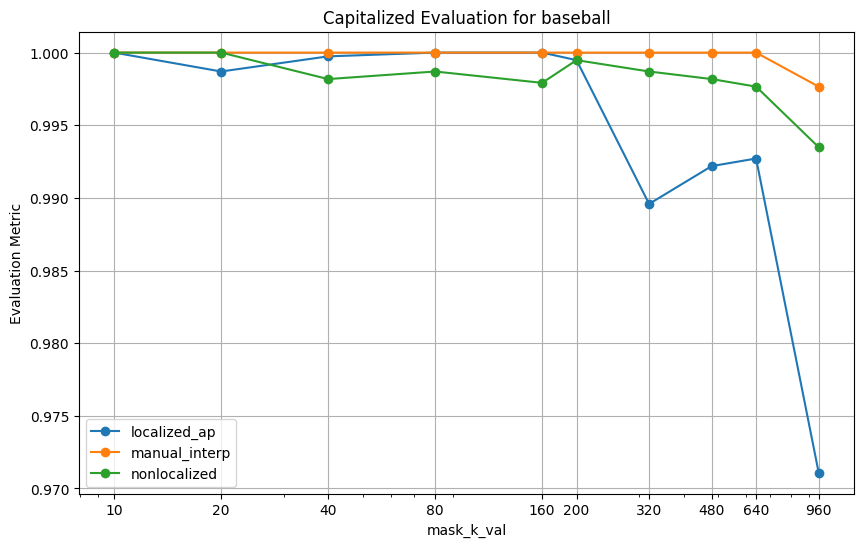

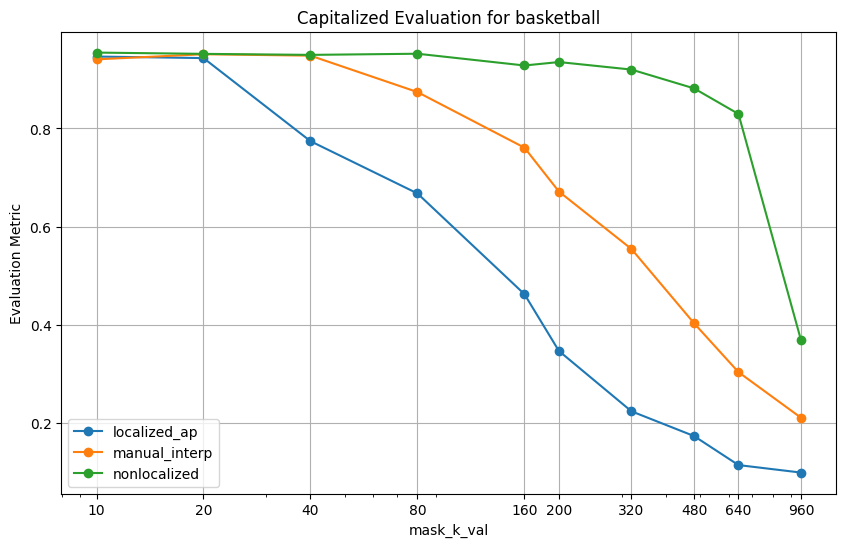

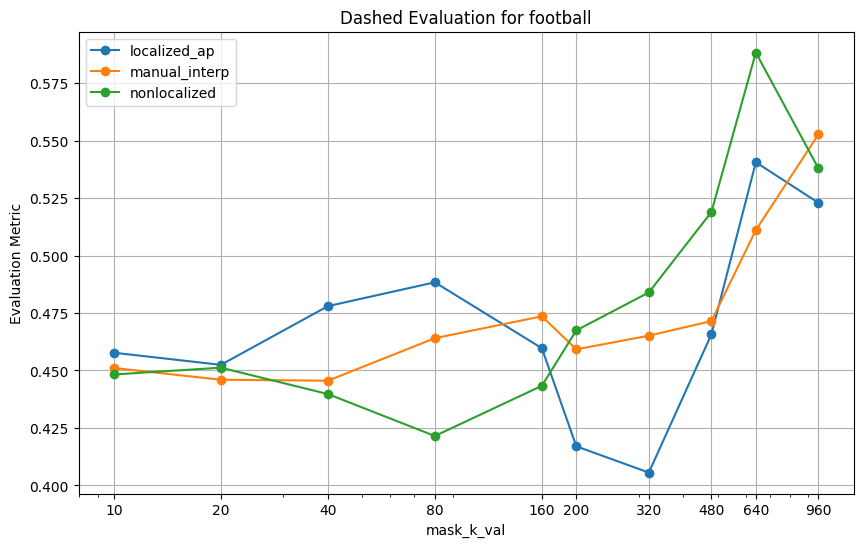

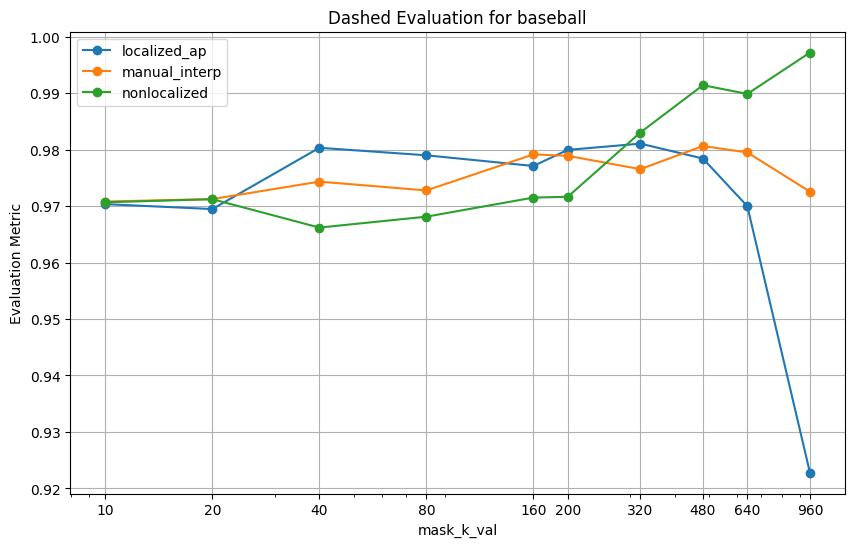

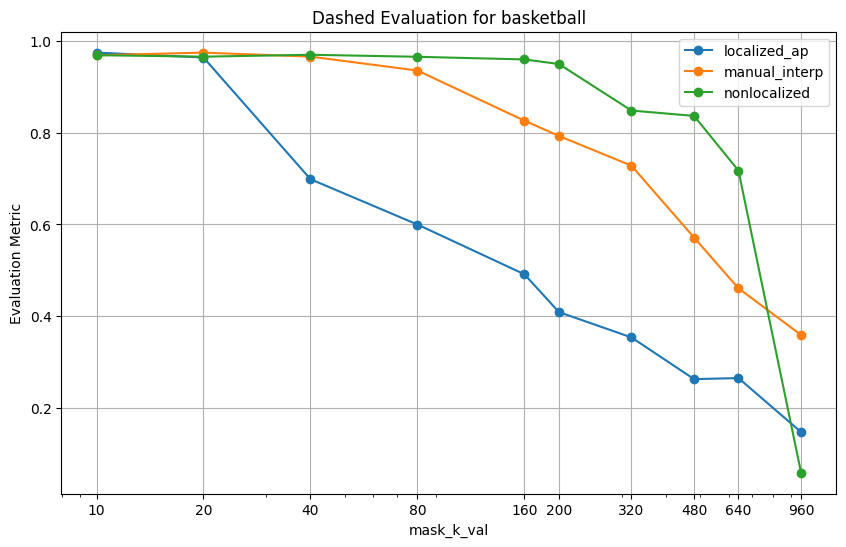

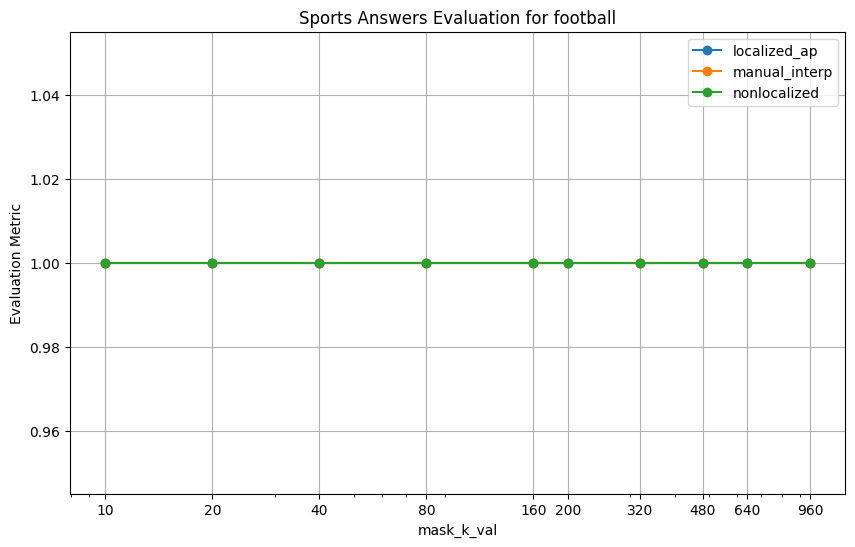

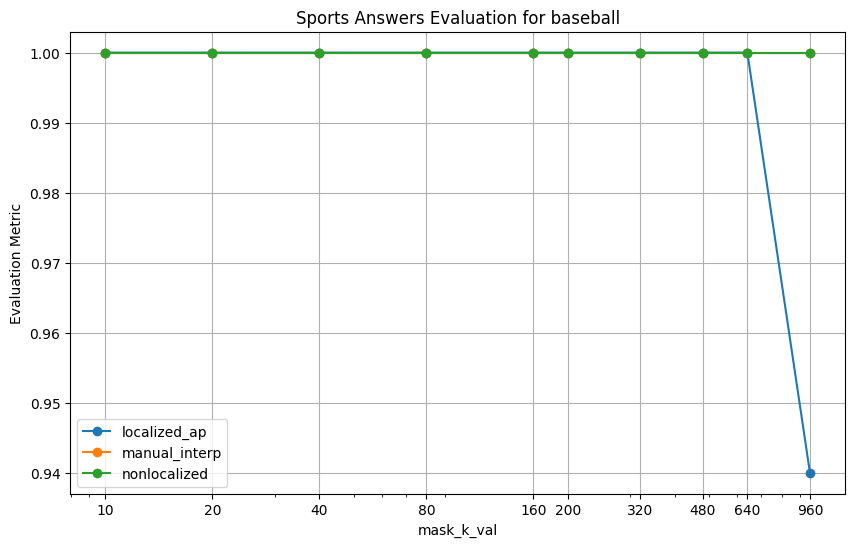

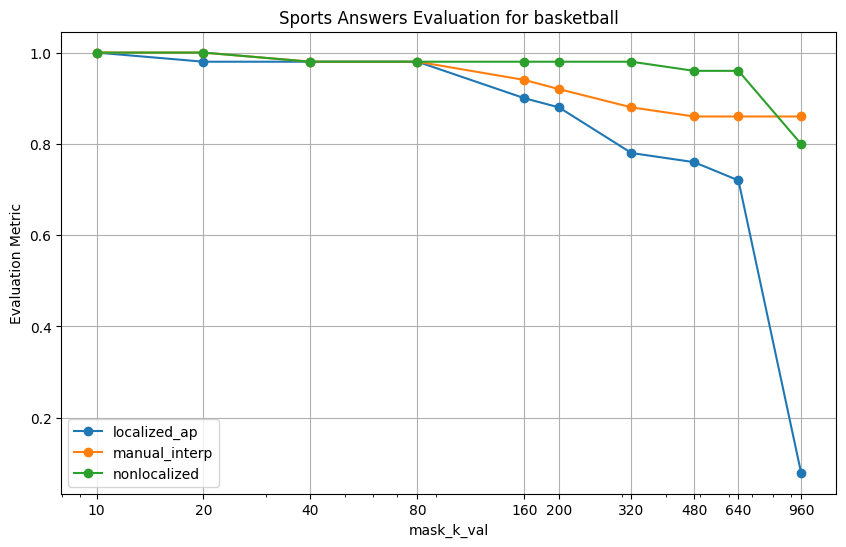

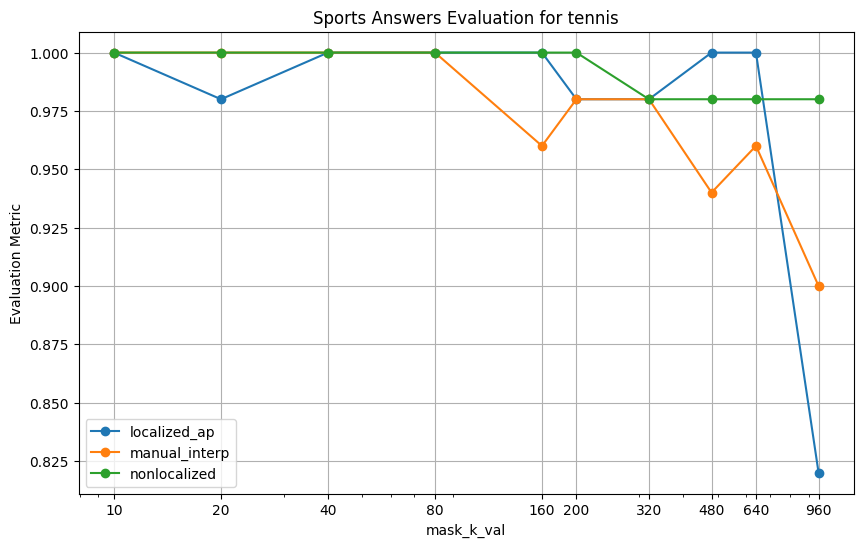

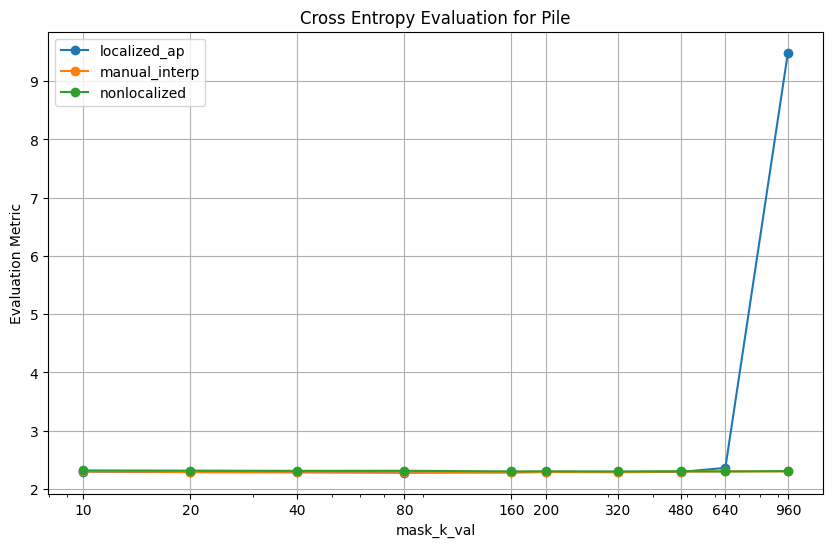

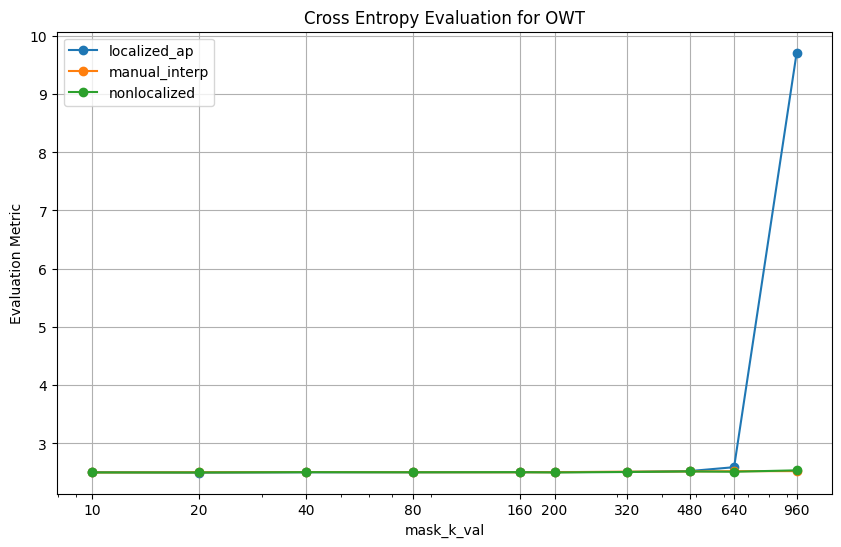

In [27]:
import pickle
beta=3
with open(f"results/neuron_cb_{beta=}_pareto_comparisons.pkl", "rb") as f:
    results = pickle.load(f)
    all_regular_evals = results['all_regular_evals']
    all_side_effect_evals = results['all_side_effect_evals']
    all_adversarial_evals = results['all_adversarial_evals']
    # localized_regular_evals = results['localized_regular_evals']
    # localized_side_effect_evals = results['localized_side_effect_evals']
    # localized_adversarial_evals = results['localized_adversarial_evals']
    # nonlocalized_regular_evals = results['nonlocalized_regular_evals']
    # nonlocalized_side_effect_evals = results['nonlocalized_side_effect_evals']
    # nonlocalized_adversarial_evals = results['nonlocalized_adversarial_evals']

import matplotlib.pyplot as plt
import numpy as np

def plot_regular_evaluations(task_regular_evals, task_name, y_label="Evaluation Metric"):
    plt.figure(figsize=(10, 6))

    sample_key = list(task_regular_evals.keys())[0]
    mask_k_vals = sorted(task_regular_evals[sample_key].keys())

    for localization_type, regular_evals in task_regular_evals.items():
        mask_k_vals = sorted(regular_evals.keys())
        scores = [regular_evals[k][task_name] for k in mask_k_vals]
        plt.plot(mask_k_vals, scores, label=localization_type, marker='o')

    # mask_k_vals = sorted(all_regular_evals['localized'].keys())

    # mask_k_vals = sorted(localized_evals.keys())
    # localized_scores = [localized_evals[k][task_name] for k in mask_k_vals]
    # nonlocalized_scores = [nonlocalized_evals[k][task_name] for k in mask_k_vals]

    # plt.plot(mask_k_vals, localized_scores, label='Localized', marker='o')
    # plt.plot(mask_k_vals, nonlocalized_scores, label='Nonlocalized', marker='o')
    plt.xlabel('mask_k_val')
    plt.ylabel(y_label)
    plt.title(f'Regular Evaluation for {task_name}')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.xticks(mask_k_vals, labels=mask_k_vals)  # Ensure ticks are set correctly for log scale
    plt.show()

# def plot_nested_evaluations_with_checks(localized_evals, nonlocalized_evals, eval_type, nested_key):
#     mask_k_vals = sorted(localized_evals.keys())
#     localized_scores = []
#     nonlocalized_scores = []

#     for k in mask_k_vals:
#         # Check and append localized scores
#         if eval_type in localized_evals[k] and nested_key in localized_evals[k][eval_type]:
#             localized_scores.append(localized_evals[k][eval_type][nested_key])
#         else:
#             localized_scores.append(None)  # or use -1 or np.nan

#         # Check and append nonlocalized scores
#         if eval_type in nonlocalized_evals[k] and nested_key in nonlocalized_evals[k][eval_type]:
#             nonlocalized_scores.append(nonlocalized_evals[k][eval_type][nested_key])
#         else:
#             nonlocalized_scores.append(None)  # or use -1 or np.nan

#     plt.figure(figsize=(10, 6))
#     plt.plot(mask_k_vals, localized_scores, label='Localized', marker='o')
#     plt.plot(mask_k_vals, nonlocalized_scores, label='Nonlocalized', marker='o')
#     plt.xlabel('mask_k_val')
#     plt.ylabel('Evaluation Metric')
#     plt.title(f'{eval_type} Evaluation for {nested_key}')
#     plt.legend()
#     plt.grid(True)
#     plt.xscale('log')  # Set x-axis to logarithmic scale
#     plt.xticks(mask_k_vals, labels=mask_k_vals)  # Ensure ticks are set correctly for log scale
#     plt.show()
def plot_nested_evaluations_with_checks(all_evals, eval_type, nested_key):
    plt.figure(figsize=(10, 6))
    mask_k_vals = sorted(next(iter(all_evals.values())).keys())  # Assuming all have the same k values

    for localization_type, evals in all_evals.items():
        scores = []
        for k in mask_k_vals:
            if eval_type in evals[k] and nested_key in evals[k][eval_type]:
                scores.append(evals[k][eval_type][nested_key])
            else:
                scores.append(None)  # or use -1 or np.nan
        plt.plot(mask_k_vals, scores, label=localization_type, marker='o')

    plt.xlabel('mask_k_val')
    plt.ylabel('Evaluation Metric')
    plt.title(f'{eval_type} Evaluation for {nested_key}')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.xticks(mask_k_vals, labels=mask_k_vals)  # Ensure ticks are set correctly for log scale
    plt.show()

# Plotting regular evaluations
# for task in ['induction', 'pile', 'forget_sport', 'maintain_sport']:

# for task in list(localized_regular_evals.values())[0].keys():
#     plot_regular_evaluations(localized_regular_evals, nonlocalized_regular_evals, task, y_label=task)
sample_key = list(all_regular_evals.keys())[0]
for task in list(all_regular_evals[sample_key].values())[0].keys():
    plot_regular_evaluations(all_regular_evals, task, y_label=task)


# Plotting adversarial evaluations
for eval_type in ['Normal', 'MC', 'Capitalized', 'Dashed']:
    for sport in ['football', 'baseball', 'basketball']:
        plot_nested_evaluations_with_checks(all_adversarial_evals, eval_type, sport)

# Plotting side effect evaluations with checks for missing keys
for eval_type in ['Sports Answers', 'Cross Entropy']:
    if eval_type == 'Sports Answers':
        for sport in ['football', 'baseball', 'basketball', 'tennis']:
            plot_nested_evaluations_with_checks(all_side_effect_evals, eval_type, sport)
    elif eval_type == 'Cross Entropy':
        for category in ['Pile', 'OWT']:
            plot_nested_evaluations_with_checks(all_side_effect_evals, eval_type, category)

# # Plotting adversarial evaluations
# # for eval_type in ['Normal', 'MC', 'Capitalized', 'Dashed']:
# for eval_type in list(localized_adversarial_evals.values())[0].keys():
#     # for sport in ['football', 'baseball', 'basketball']:
#     for sport in list(localized_adversarial_evals.values())[0][eval_type].keys():
#         plot_nested_evaluations_with_checks(localized_adversarial_evals, nonlocalized_adversarial_evals, eval_type, sport)

# # Plotting side effect evaluations with checks for missing keys
# for eval_type in ['Sports Answers', 'Cross Entropy']:
#     if eval_type == 'Sports Answers':
#         for sport in ['football', 'baseball', 'basketball', 'tennis']:
#             plot_nested_evaluations_with_checks(localized_side_effect_evals, nonlocalized_side_effect_evals, eval_type, sport)
#     elif eval_type == 'Cross Entropy':
#         for category in ['Pile', 'OWT']:
#             plot_nested_evaluations_with_checks(localized_side_effect_evals, nonlocalized_side_effect_evals, eval_type, category)